# Plot EKI Convergence Plots 

In [4]:
import os
import config 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from qbo_utils.qbo_ref import get_reference_qbo,fetch_qbo_file

BASE_EKI_EXPERIMENTS = { ## UPDATE PATHS with experiment result paths
    '5': '/Users/robcking/PhD/EKIDATA/N5',
    '10': '/Users/robcking/PhD/EKIDATA/N10',
    '20': '/Users/robcking/PhD/EKIDATA/N20',
    '50': '/Users/robcking/PhD/EKIDATA/N50',
}

period,perioderr,amplitude,amplituderr= get_reference_qbo(fetch_qbo_file(local_path='./qbo.dat'))

### Single EKI Configuration

Show a single chain of the N=10 case, showing the evolution of individual ensemble members

In [5]:
SHOW_TO  =4 # Show this main iterations of chain

dfs = dfs = [pd.read_csv(p,index_col='run_id') for p in list(sorted(glob(os.path.join(BASE_EKI_EXPERIMENTS['10'],'output_[0-9].csv'))))[:SHOW_TO]]
for df in dfs:
    df['Bt_eq'] *= 1000 # Rescale to mPa

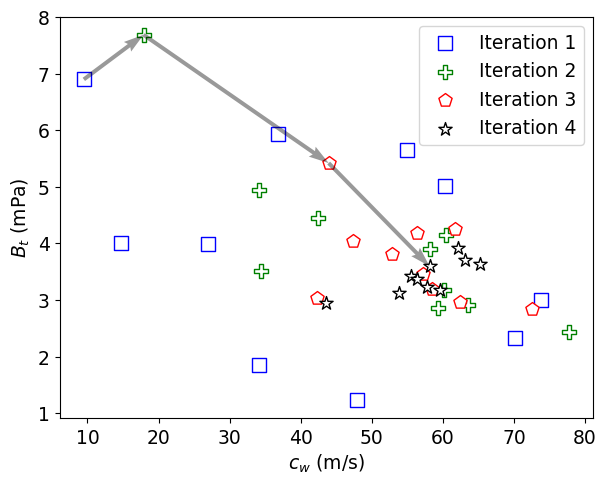

In [6]:
markers =  ['s','P','p','*','v']
colors=['blue','green','red','black']

fig,ax =plt.subplots(figsize=(6.5,5))
fig.tight_layout(pad=1.65)
zero_traj = np.array([ df.iloc[3][['cwtropics','Bt_eq']].to_numpy() for df in dfs])

for i,df in enumerate(dfs):
    df.plot.scatter(ax=ax,x='cwtropics',y='Bt_eq',marker=markers[i],s=100,label=f'Iteration {i +1}',color='white',edgecolor=colors[i])
    
for start,stop in zip(zero_traj[:-1],zero_traj[1:]):
    ax.quiver(start[0],start[1],stop[0]-start[0],stop[1]-start[1],angles='xy',scale_units='xy',scale=1,alpha=0.4)
ax.set_xlabel("$c_w$ (m/s)")
ax.set_ylabel("$B_t$ (mPa)")
ax.legend()
fig.savefig('figures/eki_conv.png',dpi=250)


### EKI Centroid Evolution
The centroid during EKI can be considered as the best single estimate of the parameter at a given iteration. 

In [13]:
import re 

def get_eki_centroid(eki_n:int):
    return np.array(
        [
            pd.read_csv(f,index_col='run_id').mean()[['cwtropics','Bt_eq']]
            for f in sorted(
                glob(
                    os.path.join(BASE_EKI_EXPERIMENTS[str(eki_n)],'output_*.csv')
                    ),
                    key=lambda x: int(
                        re.search(r'(?<=_)\d+(?=.csv)',x).group()
                    )
                )
            
        ]
    )



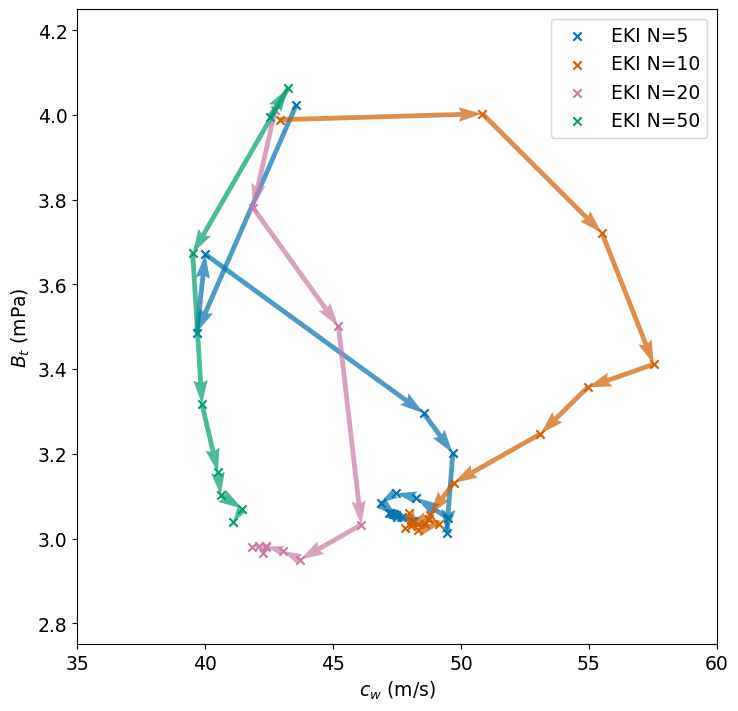

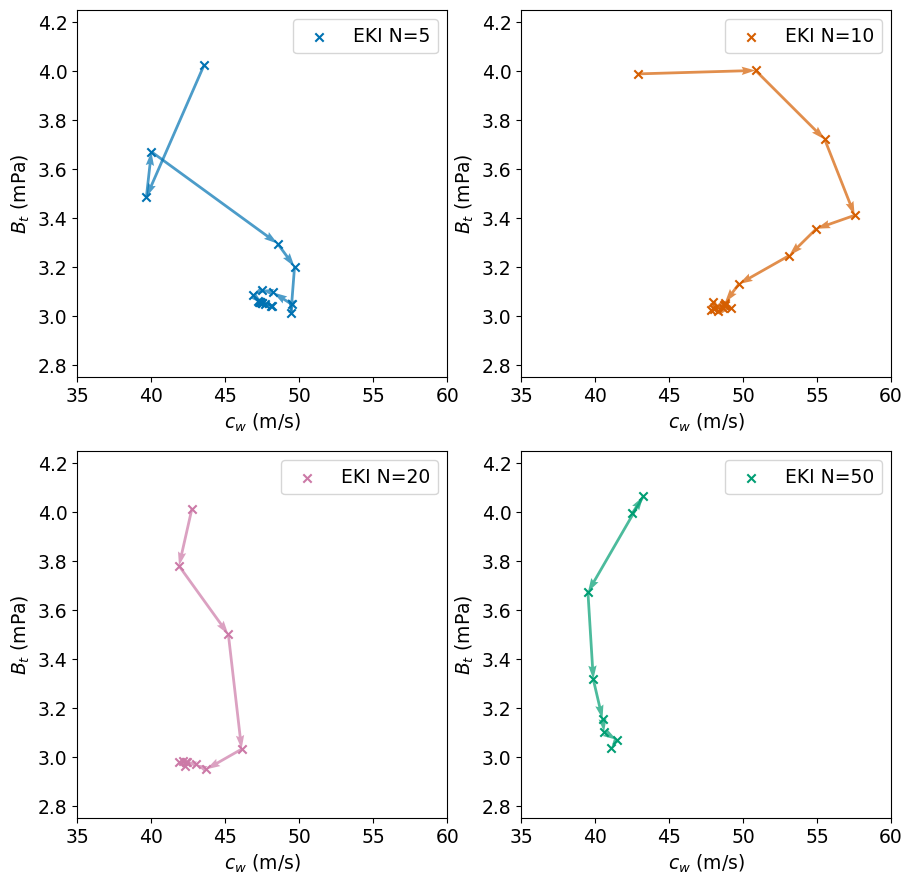

In [21]:
marker = ['x','x','x','x']
combfig,combaxs = plt.subplots(figsize=(8.25,8.25))
figs,axs = plt.subplots(2,2,figsize=(10.5,10.5))
fig.tight_layout(pad=2)
centroid_update = []
for (i,n),ax in zip(enumerate([5,10,20,50]),axs.ravel()):
    centroids = get_eki_centroid(n)
    centroid_update_n= []
    ax.scatter(centroids[:,0],centroids[:,1]*1000,label=f'EKI N={n}',marker=marker[i],c=config.COLORS[str(n)],alpha=1.0)
    combaxs.scatter(centroids[:,0],centroids[:,1]*1000,label=f"EKI N={n}",marker=marker[i],c=config.COLORS[str(n)],alpha=1.0)
    
    for start,stop in zip(centroids[:-1],centroids[1:]):
        centroid_update_n.append(np.sqrt(((stop[0]-start[0])/75)**2 + ((stop[1] -start[1])/0.006)**2))
        ax.quiver(start[0],1000*start[1],stop[0] - start[0],1000*(stop[1] - start[1]),angles='xy',scale_units='xy',scale=1.0,alpha=0.7,color=config.COLORS[str(n)])
        combaxs.quiver(start[0],1000*start[1],stop[0] - start[0],1000*(stop[1] - start[1]),angles='xy',scale_units='xy',scale=1.0,alpha=0.7,color=config.COLORS[str(n)])
    centroid_update.append(centroid_update_n)
    # plt.legend()
    ax.set_xlabel("$c_w$ (m/s)")
    ax.set_ylabel("$B_t$ (mPa)")
    ax.set_xlim(35,60)
    ax.set_ylim(2.75,4.25)
    ax.legend()
combaxs.legend()
combaxs.set_xlabel("$c_w$ (m/s)")
combaxs.set_ylabel("$B_t$ (mPa)")
combaxs.set_xlim(35,60)
combaxs.set_ylim(2.75,4.25)
figs.savefig(f'figures/eki_centroids_onefig.png',dpi=230,bbox_inches='tight')
combfig.savefig(f'figures/eki_centroids.png',dpi=230,bbox_inches='tight')



### EKI Update Vector Magnitude Convergence

In [22]:
GAMMA = np.diag([perioderr**2,amplituderr**2])
REF = np.array([period,amplitude])

def normalize(X):
    return np.array([(X[:,0]-5)/75,(X[:,1]-0.001)/(0.006)]).T

def avgdist(X):
    centroid = X.mean(axis=0)
    return np.sqrt(np.mean(np.sum((X-centroid)**2,axis=1)))


def get_stats(eki_n:int,gamma,ref):
    mags = []
    traces = []
    dets = []
    spreads = []
    vectors = []
    for f in sorted(glob(os.path.join(BASE_EKI_EXPERIMENTS[str(eki_n)],'output_*.csv')),key=lambda x: int(re.search(r'(?<=_)\d+(?=.csv)',x).group())):
        # norm
        df = pd.read_csv(f,index_col='run_id')
        X = df[['cwtropics','Bt_eq']].to_numpy()
        try:
            y = df[['period','amplitude']].to_numpy()
        except KeyError:
            continue
        y_err =df[['period_sem','amplitude_sem']].to_numpy()
        X = normalize(X)
        Cgg = np.cov(y,rowvar=False)
        Cthetag = ((X-X.mean(axis=0)).T @ (y-y.mean(axis=0)))/X.shape[0]
        update = Cthetag@np.linalg.inv(Cgg +gamma + np.diag(y_err**2))
        update_vectors = np.linalg.solve((Cgg + gamma+np.diag(y_err**2))[None,:,:],ref-y)@Cthetag ## more numerically stable
        mags.append(np.linalg.norm(update))
        traces.append(np.trace(update))
        dets.append(np.linalg.det(update))
        spreads.append(avgdist(X))
        vectors.append(update_vectors)
    return np.array(mags),np.array(traces),np.array(dets),np.array(spreads),np.array(vectors)
vals = [ get_stats(n,gamma=GAMMA,ref=REF) for n in [5,10,20,50]]

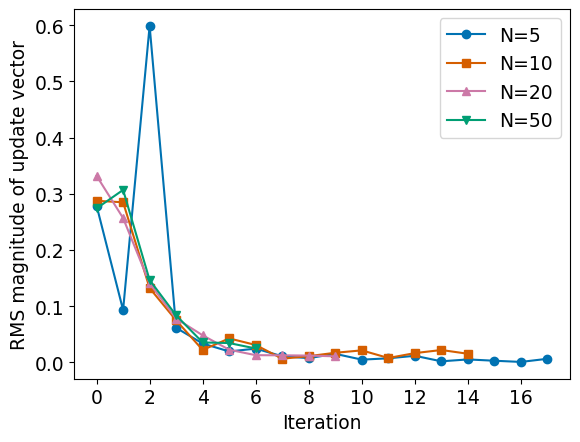

In [25]:
from matplotlib.ticker import MaxNLocator
markers = ['o','s','^','v']
for i,n in enumerate([5,10,20,50]):
    update_vectors = vals[i][-1]
    # x = np.arange(0,len(update_vectors)*n,n)
    y = (np.sqrt(np.mean(np.sum(update_vectors**2,axis=-1),axis=-1)))
    plt.plot(y,label=f'N={n}',color=config.COLORS[str(n)],marker=markers[i])
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Iteration")
    ax.set_ylabel("RMS magnitude of update vector")
    ax.legend()
    plt.savefig('figures/eki_update_vector_convergence.png',dpi=300)
    